# Problem 1 cont

## 1.5 Depoy ONNX server

Adapting tutorial at https://github.com/onnx/tutorials/blob/master/tutorials/OnnxRuntimeServerSSDModel.ipynb to my Fries/Popcorn SSD

Running the following elsewhere:

`sudo docker run -it -v $(pwd)/models:$(pwd)/models -p 9001:8001 mcr.microsoft.com/onnxruntime/server --model_path $(pwd)/models/mb1-ssd.onnx`

In [2]:
# send requests to model
import numpy as np
import assets.onnx_ml_pb2 as onnx_ml_pb2
import assets.predict_pb2 as predict_pb2
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
# add pytorch-ssd methods to path
import sys
sys.path.insert(1, '/home/redmondj/pytorch-ssd/')
from vision.datasets.open_images import OpenImagesDataset
from vision.transforms import *
from vision.ssd.data_preprocessing import PredictionTransform

In [4]:
dataset = OpenImagesDataset('/home/redmondj/data/open_images', dataset_type="test")
classes = dataset.class_names

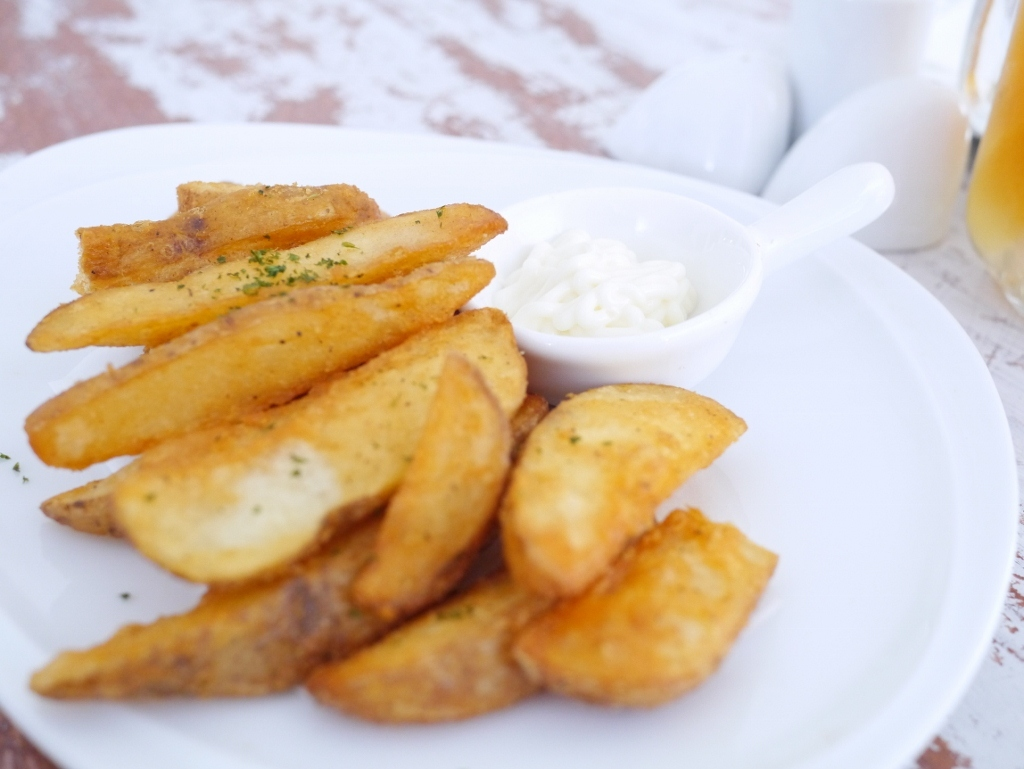

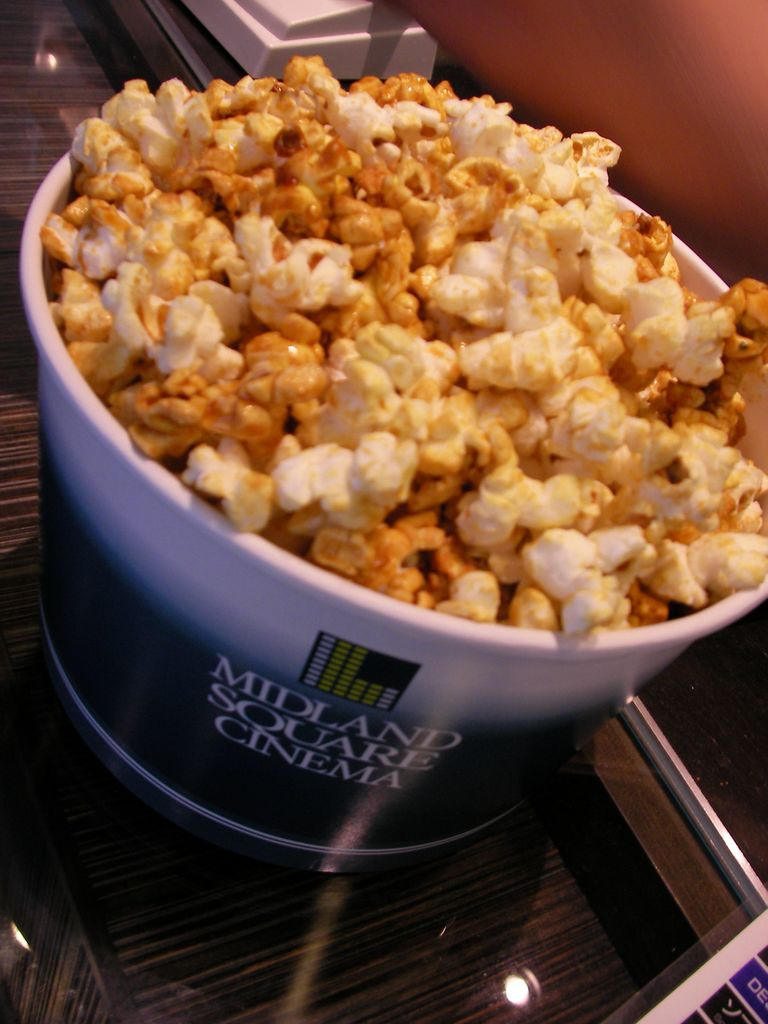

In [37]:
id_fries = 5
id_popcorn = 102

for i in [id_fries, id_popcorn]:
    image = Image.fromarray(dataset.get_image(i))
    image.show()

In [6]:
# preprocess image
def get_image(id):
    transform = PredictionTransform(size = 300, mean = np.array([127, 127, 127]), std = 128.0)

    image = dataset.get_image(id)

    height, width, _ = image.shape
    image = transform(image)
    images = image.unsqueeze(0)
    images_np = images.numpy()
    return images_np

In [7]:
# Create request message to be sent to the ORT server

def prep_request(image_np: np.ndarray):
    input_tensor = onnx_ml_pb2.TensorProto()
    input_tensor.dims.extend(image_np.shape)
    input_tensor.data_type = 1
    input_tensor.raw_data = image_np.tobytes()

    request_message = predict_pb2.PredictRequest()

    # For your model, the inputs name should be something else customized by yourself. Use Netron to find out the input name.
    input_name = 'input.1'
    request_message.inputs[input_name].data_type = input_tensor.data_type
    request_message.inputs[input_name].dims.extend(input_tensor.dims)
    request_message.inputs[input_name].raw_data = input_tensor.raw_data

    content_type_headers = ['application/x-protobuf', 'application/octet-stream', 'application/vnd.google.protobuf']

    for h in content_type_headers:
        request_headers = {
            'Content-Type': h,
            'Accept': 'application/x-protobuf'
        }
    
    return request_headers, request_message

In [8]:
# Parse response message
def parse_response(response):

    response_message = predict_pb2.PredictResponse()
    response_message.ParseFromString(response.content)

    # For your model, the outputs names should be something else customized by yourself. Use Netron to find out the outputs names.
    bboxes = np.frombuffer(response_message.outputs['boxes'].raw_data, dtype=np.float32)
    scores = np.frombuffer(response_message.outputs['scores'].raw_data, dtype=np.float32)
    labels = np.argmax(scores.reshape(response_message.outputs['scores'].dims), axis = 2)[0]

    print('Boxes shape:', response_message.outputs['boxes'].dims)
    print('Labels shape:', labels.shape)
    print('Scores shape:', response_message.outputs['scores'].dims)
    return bboxes, labels, scores

In [19]:
## Display image with bounding boxes and appropriate class 
def show_image_with_bbox(image, bboxes, labels):

    # Plot the bounding boxes on the image
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(np.moveaxis(image[0], 0, -1))

    resized_width = 300  # we resized the original image, remember ? 
    resized_height = 300
    num_boxes = 1 # The results are already sorted based on box confidences, so we just pick top N boxes without sorting

    for c in range(2999, 2999 - num_boxes, -1):
        base_index = c * 4
        y1, x1, y2, x2 = bboxes[base_index] * resized_height, bboxes[base_index + 1] * resized_width, bboxes[base_index + 2] * resized_height, bboxes[base_index + 3] * resized_width 
        color = 'blue'
        box_h = (y2 - y1)
        box_w = (x2 - x1)
        bbox = patches.Rectangle((y1, x1), box_h, box_w, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(y1, x1, s=classes[labels[c] - 1], color='white', verticalalignment='top', bbox={'color': color, 'pad': 0})
    plt.axis('off')

    plt.show()

## Fries image

In [38]:
image = get_image(id_fries)
request_headers, request_message = prep_request(image)

In [39]:
PORT_NUMBER = 9001
inference_url = "http://127.0.0.1:" + str(PORT_NUMBER) + "/v1/models/default/versions/1:predict"
response = requests.post(inference_url, headers=request_headers, data=request_message.SerializeToString())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Boxes shape: [1, 3000, 4]
Labels shape: (3000,)
Scores shape: [1, 3000, 3]


<Figure size 432x288 with 0 Axes>

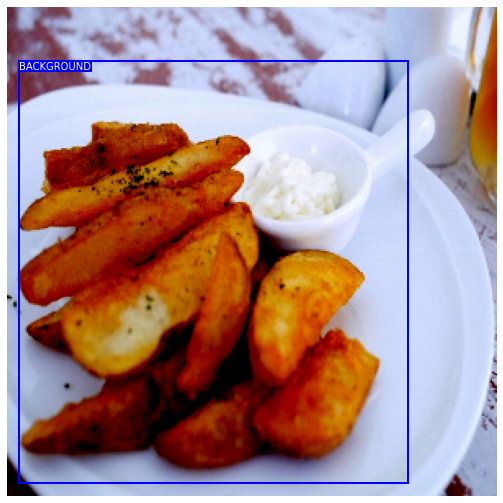

In [40]:
bboxes, labels, scores = parse_response(response)
show_image_with_bbox(image, bboxes, labels)

## Popcorn image

In [24]:
image = get_image(id_popcorn)
request_headers, request_message = prep_request(image)

In [25]:
PORT_NUMBER = 9001
inference_url = "http://127.0.0.1:" + str(PORT_NUMBER) + "/v1/models/default/versions/1:predict"
response = requests.post(inference_url, headers=request_headers, data=request_message.SerializeToString())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Boxes shape: [1, 3000, 4]
Labels shape: (3000,)
Scores shape: [1, 3000, 3]


<Figure size 432x288 with 0 Axes>

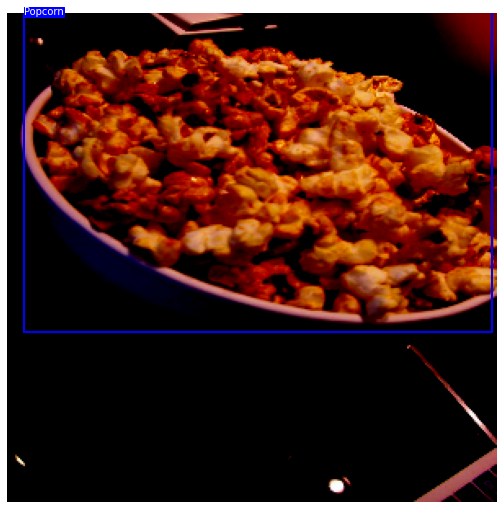

In [26]:
bboxes, labels, scores = parse_response(response)
show_image_with_bbox(image, bboxes, labels)